# Human Triplet Label Data Analysis

* 사람으로부터 수집된 image triplet에 대한 label 결과를 분석한다.
* 먼저 inter-user agreement 지표를 집계한다.
* 그 후 알고리즘과 사람의 agreement를 집계한다.
* 집계 지표는 (Gordo and Larlus, 2017)를 따른다.

## Summary

### 1. Basic stats

* Triplets : 10,000
* Human Labels : 30439 (no duplicates)
* Labelers : 37
* Labelers who labeled more than 10 triplets : 35
* Total count of answers

| Left | Right | ? (both) | X (Neither) |
|:------:|:-------:|:----------:|:-------------:|
|11550 | 9834 | 6721 | 2334 |

* Distribution of the numbers of answers per triplets
| 1     | 2       | 3       | 4      |      5     |
|:-----:|:-------:|:----------:|:-------------:|:---:|
|.975 | 2383 | 3010 | 2117 | 1440 |


### 2. Inter-Human Agreement

* Agreement score among 35 labelers: **0.6901 +- 0.0408(std)**

### 3. Agreement of Baseline Algorithms

| Method   |   Agreement |
|:-------------------------------:|:------------:|
| ResNet                          | 0.5724  |
| GT S-BERT                       | 0.6071 |
| Gen S-BERT                      | 0.5406 |
| 0.55 * ResNet + 0.45 * GT S-BERT   | 0.6661 |
| 0.55 * ResNet + 0.45 * Gen S-BERT   | 0.5822 |

<!-- test_resnet_cosine                    0.572403
test_sbert                            0.497016
test_sbert_gen                        0.540560
gen_v1_resnet07_epoch_99              0.597935
gen_v1_resnet07_epoch_99_rerank       0.586437 -->


In [110]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [111]:
df_result = pd.read_csv('results_v1_201911141704_final.csv')
df_triplet = pd.read_csv('triplets_v1_201911102026.csv')
df_triplet = df_triplet.set_index('triplet_id')

In [93]:
len(df_result)

30439

In [94]:
len(df_result.drop_duplicates())

30439

## 1. Basic Stats

In [112]:
'''users and the numers of their labels'''
df_result.groupby('user_id').count()['id'].sort_values(ascending=False)

user_id
cjhan                    9017
erin122                  4908
epsilon.kim              3002
wookee3                  2422
woong.ssang              2263
edwin.kang               1283
yoomin618                1075
hexa.ai                  1039
JRW                      1013
chico2121                 519
jinhyun.b                 474
eunjin                    392
IceAmericano              345
LSW                       298
Julyeon Seo               274
Dray.Choe                 255
Jinyeong                  251
hyunji                    250
cnuh                      211
jihoon.lee                205
yejun                     200
robert.p                  136
hihello2                  102
Jonggwon                   87
motherfathergentleman      76
eos73                      73
jay.mini                   50
junojuno                   45
sungbin.lim                31
ian.theman                 31
hans                       28
kwon.g                     25
scarlett.heo               21
dh

In [113]:
'''unique users'''
l_users = list(df_result['user_id'].unique())
print(len(l_users))
print(l_users)

37
['wookee3', 'erin122', 'LSW', 'cnuh', 'hyunji', 'cjhan', 'IceAmericano', 'Julyeon Seo', 'epsilon.kim', 'eunjin', 'ian.theman', 'Dray.Choe', 'hans', 'robert.p', 'john.dublin', 'woong.ssang', 'hexa.ai', 'june.one', 'Jinyeong', 'JRW', 'yejun', 'sungbin.lim', 'edwin.kang', 'hihello', 'hihello2', 'chico2121', 'Jonggwon', 'junojuno', 'jihoon.lee', 'dhkwak', 'jay.mini', 'kwon.g', 'motherfathergentleman', 'scarlett.heo', 'yoomin618', 'jinhyun.b', 'eos73']


In [114]:
'''filter users with low answer count (<10)'''
filter_count = 10
user_count = df_result.groupby('user_id').count()['id']
l_filtered_users = (user_count[user_count > filter_count]).index.to_list()
print(l_filtered_users)
print(len(l_filtered_users))

['Dray.Choe', 'IceAmericano', 'JRW', 'Jinyeong', 'Jonggwon', 'Julyeon Seo', 'LSW', 'chico2121', 'cjhan', 'cnuh', 'dhkwak', 'edwin.kang', 'eos73', 'epsilon.kim', 'erin122', 'eunjin', 'hans', 'hexa.ai', 'hihello', 'hihello2', 'hyunji', 'ian.theman', 'jay.mini', 'jihoon.lee', 'jinhyun.b', 'junojuno', 'kwon.g', 'motherfathergentleman', 'robert.p', 'scarlett.heo', 'sungbin.lim', 'wookee3', 'woong.ssang', 'yejun', 'yoomin618']
35


In [10]:
'''frequency of answers'''
df_result.pivot_table(index='triplet_id', columns='answer', values='user_id', aggfunc='count').fillna(0).sum()

answer
0    11550.0
1     9834.0
2     6721.0
3     2334.0
dtype: float64

In [11]:
'''answers per question'''
df_result.groupby('triplet_id').count().groupby('id').count()

,user_id,answer
id,,
1,975,975
2,2383,2383
3,3010,3010
4,2117,2117
5,1440,1440


In [190]:
# df_result = df_result[df_result['user_id'].apply(lambda x: x in {'cjhan', 'erin122', 'wookee3', 'epsilon.kim', 'edwin.kang', 'yoomin618', 'hexa.ai', 'woong.ssang'})]

In [12]:
len(df_result)

30439

## 2. Inter-user agreement score for each user

### Agreement metric from (Grodo and Larlus, 2017)
For each triplet,

$o1, o2$: the number of times the first (resp. second) image was chosen.  
$o3$: the number of times people did not pick any of the two images.  

Agreement score is computed as 

$$
s = (\frac{o_1+o_2 - 1}{o_1 + o_2 + o_3 - 1}) (\frac{o_i - 1}{o_1 + o_2 - 1})
$$
where $o_i$ $i\in\{1,2\}$ is the choice of the user.

## Our agreement metric
Let  
$o1, o2$ : the number of times the first (resp. second) image was chosen.  
$p$ : the number of times both of images were chosen  
$q$ : the nubmer of times neither of images were chosen


If a person choses the first or the second image,  
$$
s = \frac{o_i + 0.5 p - 1}{o_1 + o2 + p + q - 1}
$$
where $o_i$ $i\in\{1,2\}$ is the choice of the user.

If a person choses the "both" option,
$$
s = \frac{0.5o_1 + 0.5o_2 + p - 1}{o_1 + o_2 + p + q - 1}
$$

If a person choses the "neither" options,
$$
s = 0
% s = \frac{q - 1}{o_1 + o_2 + p + q - 1}
$$

Given a person, the score is averaged over the whole triplet which he/she labeled.

In [115]:
'''prepare answer_cnt'''
answer_cnt = df_result[['id', 'triplet_id', 'answer']].pivot_table(index='triplet_id', columns='answer', aggfunc='count').fillna(0)
answer_cnt.columns = answer_cnt.columns.droplevel(0)
answer_cnt = answer_cnt.rename(columns={0:'o1', 1:'o2', 2:'both', 3:'neither'})
answer_cnt['o3'] = answer_cnt['both'] + answer_cnt['neither']
answer_cnt.head()

answer,o1,o2,both,neither,o3
triplet_id,,,,,
1,1.0,2.0,0.0,0.0,0.0
2,0.0,2.0,2.0,0.0,2.0
3,4.0,0.0,1.0,0.0,1.0
4,0.0,3.0,0.0,0.0,0.0
5,5.0,0.0,0.0,0.0,0.0


In [98]:
'''user agreement'''
user_agree = {'user': [], 'score': []}
# for user in l_users:
for user in l_filtered_users:    
    print(user)
    df_answer_person = df_result[df_result['user_id'] == user].sort_values('triplet_id')
    l_score = []
    for i, row in df_answer_person.iterrows():
        triplet_id = row['triplet_id']
        if row['answer'] not in (0, 1, 2):
            continue

        answer = answer_cnt.loc[triplet_id]
        o1, o2, o3, p, q = answer['o1'], answer['o2'], answer['o3'], answer['both'], answer['neither']

#         o1, o2 = answer['o1'], answer['o2']
#         o3 = len(l_users) - o1 - o2

        # requires more than two active votes for the triplet
        if o1 + o2 < 2:
            continue

        if row['answer'] in {0, 1}:
            if row['answer'] == 0:
                oi = o1
            else:
                oi = o2
            s = (oi + 0.5 * p  - 1) / (o1 + o2 + p + q - 1)
        elif row['answer'] == 2:
            s = (0.5 * o1 + 0.5 * o2 + p - 1 ) / (o1 + o2 + p + q - 1)
        else:
            s = 0
#             s = (q - 1) / (o1 + o2 + p + 1 - 1)
        

#         s = (o1 + o2 - 1) / (o1 + o2 + o3 - 1) * (oi - 1) / (o1 + o2 - 1)
        

        l_score.append(s)
    score = np.mean(l_score)
    user_agree['user'].append(user)
    user_agree['score'].append(score)
user_agree = pd.DataFrame(user_agree)    
user_agree.head()
print(user_agree.mean(), user_agree.std())

Dray.Choe
IceAmericano
JRW
Jinyeong
Jonggwon
Julyeon Seo
LSW
chico2121
cjhan
cnuh
dhkwak
edwin.kang
eos73
epsilon.kim
erin122
eunjin
hans
hexa.ai
hihello
hihello2
hyunji
ian.theman
jay.mini
jihoon.lee
jinhyun.b
junojuno
kwon.g
motherfathergentleman
robert.p
scarlett.heo
sungbin.lim
wookee3
woong.ssang
yejun
yoomin618
score    0.690198
dtype: float64 score    0.040811
dtype: float64


## Agreement between algorithm and human

Let  
$o1, o2$ : the number of times the first (resp. second) image was chosen.  
$p$ : the number of times "both" icon were chosen  
$q$ : the nubmer of times "neither" icon of images were chosen


If an algorithm choses the first or the second image, it recieves the following agreement score  
$$
s = \frac{o_i + 0.5 p - 1}{o_1 + o_2 + p + q - 1}
$$
where $o_i$ $i\in\{1,2\}$ is the choice of the algorithm.

In [116]:
def read_similarity_data(algo, df_triplet):
    '''pre-fetch similarity scores'''
    d_sim = {}
    result_path = '/data/project/rw/viewer_CBIR/viewer/results/'
    for query_id, by_qid in df_triplet.groupby('query_id'):
        l_target_ids = list(by_qid['target_id1']) + list(by_qid['target_id2'])
        
        data = pd.read_csv(os.path.join(result_path, algo, f'{query_id}.tsv'), delimiter='\t', header=None)
        data = data.rename(columns={0:'id', 1:'sim'}).set_index('id')
#         sim = data.loc[[int(s) for s in l_target_ids]].to_dict()['sim']
        sim = data.reindex([int(s) for s in l_target_ids]).to_dict()['sim']
        d_sim[query_id] = sim
    return d_sim

In [117]:
def read_result(algo, query_id, l_target_ids):
    result_path = '/data/project/rw/viewer_CBIR/viewer/results/'
    data = pd.read_csv(os.path.join(result_path, algo, f'{query_id}.tsv'), delimiter='\t', header=None)
    data = data.rename(columns={0:'id', 1:'sim'}).set_index('id')
    return data.loc[[int(s) for s in l_target_ids]].to_dict()['sim']

In [118]:
# l_algorithms = ['test_resnet_cosine', 'test_sbert', 'test_sbert_gen']
#                 'gen_v1_resnet07_epoch_99', 'gen_v1_resnet07_epoch_99_rerank']
# l_algorithms = ['v1_meansbert_gen_epoch_37', 'v1_meansbert_gen_epoch_37_rerank', 'han_meansbert_gen_epoch_36', 'han_meansbert_gen_epoch_36_rerank']
l_algorithms = ['test_sbert_allcap_rerank',]
# l_algorithms = ['v1_resnetweight05_epoch_10_rerank', 'gen_v1_resnet07_epoch_99_rerank', 'gen_v1_resnet07_epoch_99']
algo_scores = {'triplet_id': list(answer_cnt.index)}
d_resnet_sim = read_similarity_data('test_resnet_cosine', df_triplet)
for algo in tqdm(l_algorithms):
    d_sim_result = read_similarity_data(algo, df_triplet)
    l_score = []
    for triplet_id, row in answer_cnt.iterrows():
        o1, o2, o3, p, q = row['o1'], row['o2'], row['o3'], row['both'], row['neither']

        if o1 + o2  < 2:
            l_score.append(np.nan)
            continue
            
        # get algorithm's prediction
        triplet = df_triplet.loc[triplet_id]
        sim1 = d_sim_result[triplet['query_id']][triplet['target_id1']]
        sim2 = d_sim_result[triplet['query_id']][triplet['target_id2']]
        
        # process reranking
        if (np.isnan(sim1)) and (np.isnan(sim2)):
            sim1 = d_resnet_sim[triplet['query_id']][triplet['target_id1']]
            sim2 = d_resnet_sim[triplet['query_id']][triplet['target_id2']]
        elif (np.isnan(sim1)) and not (np.isnan(sim2)):
            sim1 = - np.inf
        elif not (np.isnan(sim1)) and (np.isnan(sim2)):
            sim2 = - np.inf
        
        if sim1 > sim2:
            oi = o1
        else:
            oi = o2
        
        s = (oi + 0.5 * p ) / (o1 + o2 + p + q )
        l_score.append(s)
    algo_scores[algo] = l_score
algo_scores = pd.DataFrame(algo_scores)


100%|██████████| 1/1 [00:16<00:00, 16.25s/it]


In [119]:
algo_scores.mean()

triplet_id                  4995.389622
test_sbert_allcap_rerank       0.612267
dtype: float64

In [100]:
algo_scores.mean()

triplet_id                           4995.389622
v1_meansbert_gen_epoch_37               0.600697
v1_meansbert_gen_epoch_37_rerank        0.589254
han_meansbert_gen_epoch_36              0.569594
han_meansbert_gen_epoch_36_rerank       0.583270
dtype: float64

In [102]:
algo_scores.mean()

triplet_id                 4995.389622
gwl_rerank                    0.580386
gwl_gen_wordonly_rerank       0.590975
dtype: float64

In [62]:
'''linear combination'''
weights = np.linspace(0,1,21)
d_resnet = read_similarity_data('test_resnet_cosine', df_triplet)
d_sbert = read_similarity_data('test_sbert_gen', df_triplet)
# d_sbert = read_similarity_data('test_sbert', df_triplet)
algo_scores = {'triplet_id': list(answer_cnt.index)}
for w in tqdm(weights):

    l_score = []
    for triplet_id, row in answer_cnt.iterrows():
        o1, o2, o3, p, q = row['o1'], row['o2'], row['o3'], row['both'], row['neither']

        if o1 + o2  < 2:
            l_score.append(np.nan)
            continue
            
        # get algorithm's prediction
        
        triplet = df_triplet.loc[triplet_id]
        sim1_res = d_resnet[triplet['query_id']][triplet['target_id1']]
        sim2_res = d_resnet[triplet['query_id']][triplet['target_id2']]
        sim1_sbert = d_sbert[triplet['query_id']][triplet['target_id1']]
        sim2_sbert = d_sbert[triplet['query_id']][triplet['target_id2']]
        sim1 = w * sim1_res + (1 - w) * sim1_sbert
        sim2 = w * sim2_res + (1 - w) * sim2_sbert
        
#         pred_sim = read_result(algo, triplet['query_id'], [triplet['target_id1'], triplet['target_id2']])
#         sim1, sim2 = pred_sim[triplet['target_id1']], pred_sim[triplet['target_id2']]
        
        if sim1 > sim2:
            oi = o1
        else:
            oi = o2
        
        s = (oi + 0.5 * p ) / (o1 + o2 + p + q )
    #     print(o1, o2, o3, oi, s)
        l_score.append(s)
    algo_scores[f'mix{w:.3f}'] = l_score
algo_scores = pd.DataFrame(algo_scores)


100%|██████████| 21/21 [01:29<00:00,  4.28s/it]


In [63]:
l_gen_sbert_align = algo_scores.mean().to_list()[1:]

Text(0.5, 0, 'resnet mixing ratio')

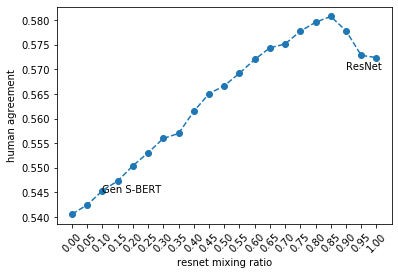

In [64]:
plt.plot(weights, l_gen_sbert_align, '--o')
plt.xticks(weights, rotation=45);
# plt.ylim([0,None])
plt.text(0.1, 0.545, 'Gen S-BERT')
plt.text(0.9, 0.57, 'ResNet')
plt.ylabel('human agreement')
plt.xlabel('resnet mixing ratio')

Text(0.5, 0, 'resnet mixing ratio')

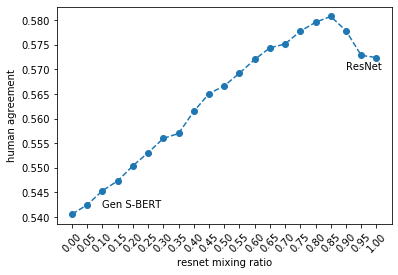

In [37]:
plt.plot(weights, l_human_align, '--o')
plt.xticks(weights, rotation=45);
# plt.ylim([0,None])
plt.text(0.1, 0.542, 'Gen S-BERT')
plt.text(0.9, 0.57, 'ResNet')
plt.ylabel('human agreement')
plt.xlabel('resnet mixing ratio')

In [22]:
np.max(l_human_align)

0.5821519023772528

Text(0.5, 0, 'resnet mixing ratio')

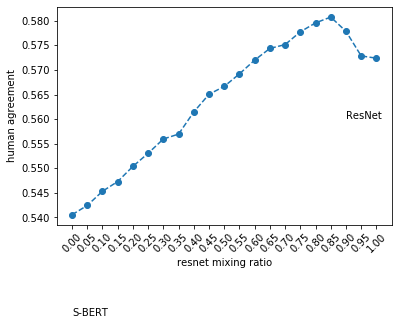

In [35]:
plt.plot(weights, l_human_align, '--o')
plt.xticks(weights, rotation=45);
# plt.ylim([0,None])
plt.text(0, 0.52, 'S-BERT')
plt.text(0.9, 0.56, 'ResNet')
plt.ylabel('human agreement')
plt.xlabel('resnet mixing ratio')

## Alternative S-BERT Similarities

In [39]:
import h5py

In [40]:
sbert_allcap_file = '/data/project/rw/medical_sg/sbert_allcaps_sims_batch.hdf5'
f = h5py.File(sbert_allcap_file, 'r')

In [46]:
class BERTSimilarityInMemV2:
    """class for handling SBERT similarity file from IMLAB
    Identical to BERTSimilarity, but loads all similarity metric in memory"""
    def __init__(self, file_path, key='mean'):
        with h5py.File(file_path, 'r') as f:
            self.idx_lookup = {str(img_id): idx for idx, img_id in enumerate(f['id'])}
            self.sims = {}
            for k, v in tqdm(f[key].items()):
                self.sims[k] = v[:]
            # self.sims = {k: v[:] for k, v in f['sims'].items()}

    def get_similarity(self, img_id_1, img_id_2):
        img_idx_2 = self.idx_lookup[str(img_id_2)]
        return self.sims[str(img_id_1)][img_idx_2]

In [51]:
sim_mean = BERTSimilarityInMemV2(sbert_allcap_file, 'mean')
sim_max = BERTSimilarityInMemV2(sbert_allcap_file, 'max')

100%|██████████| 1000/1000 [00:00<00:00, 1534.09it/s]


In [17]:
def read_similarity_data_h5py(algo, df_triplet):
    '''pre-fetch similarity scores'''
    d_sim = {}
    result_path = '/data/project/rw/viewer_CBIR/viewer/results/'
    for query_id, by_qid in df_triplet.groupby('query_id'):
        l_target_ids = list(by_qid['target_id1']) + list(by_qid['target_id2'])
        
        data = pd.read_csv(os.path.join(result_path, algo, f'{query_id}.tsv'), delimiter='\t', header=None)
        data = data.rename(columns={0:'id', 1:'sim'}).set_index('id')
#         sim = data.loc[[int(s) for s in l_target_ids]].to_dict()['sim']
        sim = data.reindex([int(s) for s in l_target_ids]).to_dict()['sim']
        d_sim[query_id] = sim
    return d_sim

In [52]:
simsim = sim_mean
l_score = []
for triplet_id, row in answer_cnt.iterrows():
    o1, o2, o3, p, q = row['o1'], row['o2'], row['o3'], row['both'], row['neither']

    if o1 + o2  < 2:
        l_score.append(np.nan)
        continue

    # get algorithm's prediction
    triplet = df_triplet.loc[triplet_id]
    sim1 = simsim.get_similarity(triplet['query_id'], triplet['target_id1'])
    sim2 = simsim.get_similarity(triplet['query_id'], triplet['target_id2'])    

    if sim1 > sim2:
        oi = o1
    else:
        oi = o2

    s = (oi + 0.5 * p ) / (o1 + o2 + p + q )
    l_score.append(s)
np.nanmean(l_score)

0.6071174863387978

In [53]:
simsim = sim_max
l_score = []
for triplet_id, row in answer_cnt.iterrows():
    o1, o2, o3, p, q = row['o1'], row['o2'], row['o3'], row['both'], row['neither']

    if o1 + o2  < 2:
        l_score.append(np.nan)
        continue

    # get algorithm's prediction
    triplet = df_triplet.loc[triplet_id]
    sim1 = simsim.get_similarity(triplet['query_id'], triplet['target_id1'])
    sim2 = simsim.get_similarity(triplet['query_id'], triplet['target_id2'])    

    if sim1 > sim2:
        oi = o1
    else:
        oi = o2

    s = (oi + 0.5 * p ) / (o1 + o2 + p + q )
    l_score.append(s)
np.nanmean(l_score)

0.5779545454545454

In [50]:
np.nanmean(l_score)

0.6071174863387978

In [65]:
'''linear combination'''
weights = np.linspace(0,1,21)
d_resnet = read_similarity_data('test_resnet_cosine', df_triplet)
simsim = sim_mean
algo_scores = {'triplet_id': list(answer_cnt.index)}
for w in tqdm(weights):

    l_score = []
    for triplet_id, row in answer_cnt.iterrows():
        o1, o2, o3, p, q = row['o1'], row['o2'], row['o3'], row['both'], row['neither']

        if o1 + o2  < 2:
            l_score.append(np.nan)
            continue
            
        # get algorithm's prediction
        
        triplet = df_triplet.loc[triplet_id]
        sim1_res = d_resnet[triplet['query_id']][triplet['target_id1']]
        sim2_res = d_resnet[triplet['query_id']][triplet['target_id2']]
        sim1_sbert = simsim.get_similarity(triplet['query_id'], triplet['target_id1'])
        sim2_sbert = simsim.get_similarity(triplet['query_id'], triplet['target_id2'])  
        sim1 = w * sim1_res + (1 - w) * sim1_sbert
        sim2 = w * sim2_res + (1 - w) * sim2_sbert
        
#         pred_sim = read_result(algo, triplet['query_id'], [triplet['target_id1'], triplet['target_id2']])
#         sim1, sim2 = pred_sim[triplet['target_id1']], pred_sim[triplet['target_id2']]
        
        if sim1 > sim2:
            oi = o1
        else:
            oi = o2
        
        s = (oi + 0.5 * p ) / (o1 + o2 + p + q )
    #     print(o1, o2, o3, oi, s)
        l_score.append(s)
    algo_scores[f'mix{w:.3f}'] = l_score
algo_scores = pd.DataFrame(algo_scores)


100%|██████████| 21/21 [01:37<00:00,  4.66s/it]


In [66]:
l_mean_sbert_align = algo_scores.mean().to_list()[1:]

Text(0.5, 0, 'resnet mixing ratio')

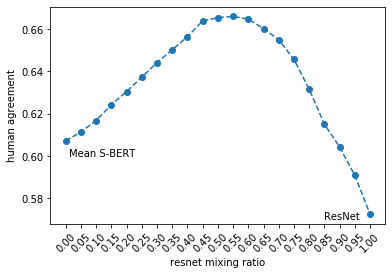

In [67]:
plt.plot(weights, l_mean_sbert_align, '--o')
plt.xticks(weights, rotation=45);
# plt.ylim([0,None])
plt.text(0.01, 0.6, 'Mean S-BERT')
plt.text(0.85, 0.57, 'ResNet')
plt.ylabel('human agreement')
plt.xlabel('resnet mixing ratio')

In [60]:
np.max(l_human_align)

0.6660842026825639

## Figure

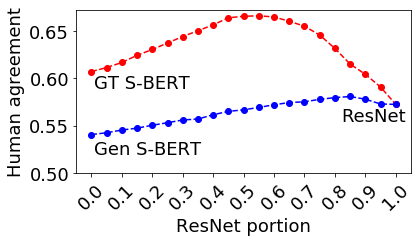

In [88]:
plt.figure(figsize=(6,3))
plt.rcParams.update({'font.size':18})
plt.plot(weights, l_mean_sbert_align, '--or', )
plt.plot(weights, l_gen_sbert_align, '--ob')
plt.xticks(weights[::2], rotation=45);
# plt.ylim([0,None])
plt.text(0.01, 0.59, 'GT S-BERT')
plt.text(0.01, 0.52, 'Gen S-BERT')
plt.text(0.82, 0.555, 'ResNet')
plt.ylim([0.5, None])
plt.ylabel('Human agreement')
plt.xlabel('ResNet portion')
plt.savefig('fig_human_agreement.pdf', bbox_inches='tight')

In [61]:
weights[np.argmax(l_human_align)]

0.55